In [1]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz, square
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn
# set the seed
np.random.seed(2)

## Nyquist frequency for irregularly spaced time series:
* It is neccessary, to work with the fourier transform, to know the nyquist frequency of the time series witch could be irregularly spaced. For this case it is posible to get this nyquist frequency with a calculation formula. In simple words, using the following formula:
$$ SS(\nu) = \sum_{k, l} [ sin \: 2 \pi \nu (t_k - t_l)]^2 $$
    The nyquist frequency is when this is minimized, i.e. the $\nu_0$ which lead us to get $sin \: 2 \pi \nu_0 (t_k - t_l) = 0 $ for all $k, l$.
    
This calculation is descrived for the case of slight deviation of regular spacing in: The Nyquist frequency for time series with slight deviation from regular spacing C. Koen, MNRAS 401, 586; https://academic.oup.com/mnras/article/371/3/1390/1009436

### Complete procedure:
* Frist we will generate datas, one with slight deviations from regular spacing and other with large deviations, here we are asuming that we cannot have two observations at same time. Also, for reference, we will generate data with regular spaced time series
* Then we will see the periodogram of the signal, which will be at first a sinusoid with gaussian noise.
* the next step will be to calculate the $SS(\nu)$ function.
* and finally check how the method works.

In [80]:
# Generating the datas, we will use the class Signal from Regular sampling
class Signal:
    def __init__(self, frequencies=[1], weights=[1], noise=None):
        """
        it will generate a signal usign the frequencies and the weight from input.
        the frecuencies should be in Hertz and the weight is a constante of "amplitud" 
        of every sub-signal associated to avery frequency.
        weight should be a number between 0 and 1
        """
        self.frequencies = frequencies
        self.weights = weights
        self.noise = noise
    
    def sin_samples(self, times, with_noise=True):
        y = np.zeros(len(times))
        for i in range(len(self.frequencies)):
            y += self.weights[i] * np.sin(2 * np.pi * self.frequencies[i] * np.array(times))
        if with_noise:
            y += self.noise
        return y

# for the times we will consider 1 second and 100 samples.
t = 1
N = 100

# regular sampling
time_regular = np.linspace(0, 1, N)

# slight irregularities: here we will generat te times with t_j = t_j-1 + Delta_t + e_j where e_j is an small gaussian error,
# since we onli wnant 1 second, we will use a square sigma of t*0.01, and the Delta_t will be t/N
time_slight = [0]
len_time = len(time_slight)
while len_time < N:
    time_slight.append(time_slight[-1] + t/N + abs(np.random.normal(0, t*0.01)))
    len_time += 1
# large irregularities: here we will use the same formula that we used for slight irre. but with a bigger sigma and
# also we will add a large time skip at the middle, here we will have different times of observations
time_large = [0]
len_time = len(time_large)
while len_time < N:
    time_large.append(time_large[-1] + t/N + abs(np.random.normal(0, t*0.02)))
    len_time += 1
time_large[int(N/2):] += np.ones(int(N/2))*0.4

# then, using the noise:
noise =  np.random.normal(0, 1, N)
class_signal = Signal(noise=noise)
#the signal produced will be:

#regular
regular_sample = class_signal.sin_samples(time_regular)

# slight irregularities
slight_sample = class_signal.sin_samples(time_slight)

# large irregularities
large_sample = class_signal.sin_samples(time_large)

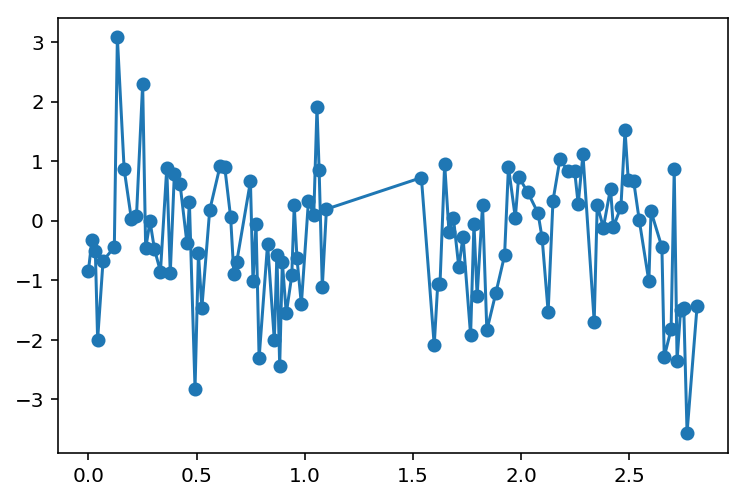

In [84]:
plt.plot(time_large, large_sample, 'o-')
# plt.plot(time_slight, slight_sample, 'ro-')
# plt.plot(time_regular, regular_sample, 'go-')